In [ ]:
import cv2
import os
import sys
import statistics
import numpy as np
from numpy import vstack
from numpy import expand_dims
import keras
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.layers import Reshape
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2DTranspose
from keras.models import load_model

from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from numpy import expand_dims
from numpy import ones
from numpy import zeros

from google.colab.patches import cv2_imshow
import tensorflow as tf
from skimage.measure import compare_ssim as ssim
from sklearn.metrics import mean_absolute_error

%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Create Dataset

In [ ]:
# # CREATE AND STORE DRAWINGS OF PEOPLE IMAGES IN NEW FOLDER
# for x in range(0,len(os.listdir('drive/My Drive/Colab Notebooks/Drawing to Real/person'))):
#   img = cv2.imread('drive/My Drive/Colab Notebooks/Drawing to Real/person/person_'+ (4-len(str(x)))*'0'+str(x) +'.jpg')
#   gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#   gray_img_inv = 255 - gray_img
#   gray_img_inv = cv2.GaussianBlur(gray_img_inv, (21,21),0)
#   output = cv2.divide(gray_img, 255 - gray_img_inv, scale = 256.0)
#   cv2.imwrite('drive/My Drive/Colab Notebooks/Drawing to Real/person drawing/person_drawing_'+(4-len(str(x)))*'0'+str(x)+'.jpg',output)
  # cv2_imshow(img)
  # cv2_imshow(output)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

In [ ]:
# # Turn all drawings (-35) into a numpy array called x_train
# # & Turn all original photos (-35) into a numpy array called y_train
# train_len = len(os.listdir('drive/My Drive/Colab Notebooks/Drawing to Real/person drawing'))-35
# x_train ,y_train = np.empty((train_len,256, 256, 3)), np.empty((train_len,256, 256, 3))
# for x in range(0,train_len):
#   try:
#     x_train[x]=np.asarray(cv2.imread('drive/My Drive/Colab Notebooks/Drawing to Real/person drawing/person_drawing_'+(4-len(str(x)))*'0'+str(x) +'.jpg'))
#     y_train[x]=np.asarray(cv2.imread('drive/My Drive/Colab Notebooks/Drawing to Real/person/person_'+(4-len(str(x)))*'0'+str(x) +'.jpg'))
#     if x%5 == 0:
#       print(x)
#   except:
#     print("Skipped:",x)
# print ("Completed:", train_len)

In [ ]:
# # Turn all original photos into a numpy array called x_train and convert to GRAYSCALE

# def rgb2gray(rgb):
#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
#     return gray

# train_len = len(os.listdir('drive/My Drive/Colab Notebooks/Drawing to Real/person drawing'))
# x_train = np.empty((train_len,256, 256))
# for x in range(0,train_len):
#   try:
#     x_train[x]=rgb2gray(np.asarray(cv2.imread('drive/My Drive/Colab Notebooks/Drawing to Real/person/person_'+(4-len(str(x)))*'0'+str(x) +'.jpg')))
#     if x%5 == 0:
#       print(x)
#   except:
#     print("Skipped:",x)
# print ("Completed:", train_len)

In [ ]:
# # SAVE TRAINING & TEST SETS AS NUMPY ARRAYS
# np.save('drive/My Drive/Colab Notebooks/Drawing to Real/x_train.npy', x_train)

In [ ]:
# LOAD DATASETS (IF ALREADY SAVED) FROM GOOGLE DRIVE
x_train = np.load('drive/My Drive/Colab Notebooks/Drawing to Real/x_train.npy')

# Add extra dimension for CNN processing and divide values by 255 to scale pixels from 0 to 1
x_train = expand_dims(x_train/255, axis=-1)

# Attempt GAN for Image Generation

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(256,256,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [ ]:
# function to load and prepare person training images
def load_real_samples():
	# convert from unsigned ints to floats
	X = x_train.astype('float32')
	return X

# function to select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y


# # function to generate n fake samples with class labels
# def generate_fake_samples(n_samples):
# 	# generate uniform random numbers in [0,1]
# 	X = rand(256 * 256 * n_samples)
# 	# reshape into a batch of grayscale images
# 	X = X.reshape((n_samples, 256, 256, 1))
# 	# generate 'fake' class labels (0)
# 	y = zeros((n_samples, 1))
# 	return X, y

# function to train the discriminator model
def train_discriminator(model, dataset, n_iter=300, n_batch=250):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim=100, n_samples=half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))


In [ ]:
g_model = load_model('drive/My Drive/Colab Notebooks/Drawing to Real/Generator Models/generator_model_166 (best).h5')

# define the discriminator model
d_model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(d_model, dataset)

>1 real=34% fake=0%
>2 real=100% fake=0%
>3 real=98% fake=1%
>4 real=37% fake=1%
>5 real=80% fake=0%
>6 real=94% fake=0%
>7 real=99% fake=0%
>8 real=100% fake=0%
>9 real=100% fake=0%
>10 real=99% fake=1%
>11 real=97% fake=1%
>12 real=98% fake=2%
>13 real=99% fake=3%
>14 real=98% fake=4%
>15 real=98% fake=6%
>16 real=95% fake=4%
>17 real=95% fake=5%
>18 real=100% fake=2%
>19 real=99% fake=12%
>20 real=96% fake=14%
>21 real=97% fake=21%
>22 real=97% fake=10%
>23 real=97% fake=16%
>24 real=98% fake=22%
>25 real=94% fake=26%
>26 real=94% fake=24%
>27 real=94% fake=31%
>28 real=98% fake=31%
>29 real=97% fake=38%
>30 real=96% fake=30%
>31 real=97% fake=38%
>32 real=90% fake=50%
>33 real=98% fake=48%
>34 real=96% fake=38%
>35 real=98% fake=48%
>36 real=96% fake=54%
>37 real=92% fake=52%
>38 real=91% fake=50%
>39 real=94% fake=53%
>40 real=93% fake=62%
>41 real=94% fake=66%
>42 real=92% fake=63%
>43 real=93% fake=72%
>44 real=92% fake=68%
>45 real=90% fake=66%
>46 real=90% fake=75%
>47 real=93

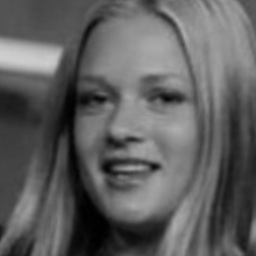

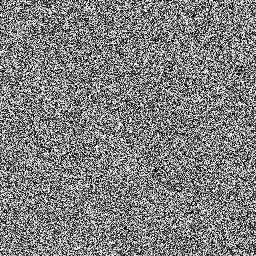

In [ ]:
cv2_imshow(x_train[0]*255)
cv2_imshow(generate_fake_samples(1)[0][0]*255)

In [ ]:
# Try 512 nodes after 

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 64x64 image
	n_nodes = 128 * 64 * 64
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((64, 64, 128)))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 256x256
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (64,64), activation='sigmoid', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
g_model = define_generator(latent_dim)
# summarize the model
g_model.summary()
# plot the model
# plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 524288)            52953088  
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 524288)            0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 128)     262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 128)     262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256, 256, 128)    

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

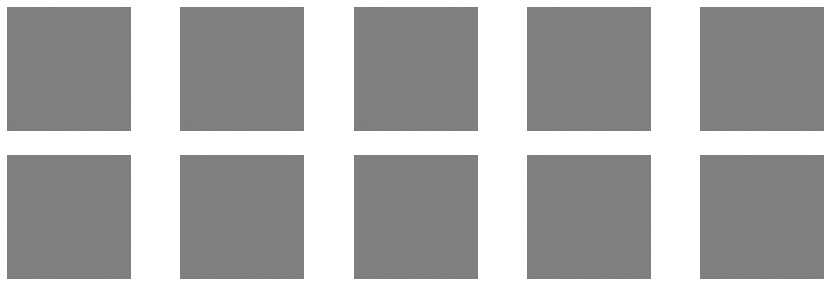

In [ ]:
# generate samples
n_samples = 10
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
X *= 255
# plot the generated samples
plt.figure(figsize=(15,5))
for i in range(n_samples):
  # define subplot
  plt.subplot(2, 5, 1 + i)
  # turn off axis labels
  plt.axis('off')
  # plot single image
  plt.imshow(X[i, :, :, 0], cmap='gray', vmin=0, vmax=255)
  # show the figure
# filename = 'drive/My Drive/Colab Notebooks/Drawing to Real/Generated Images/generated_plot_e%03d.png' % (0)
# plt.savefig(filename)
plt.show()

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ["accuracy"])
	return model

	# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
  # plot images
  plt.figure(figsize=(15,5))
  for i in range(n):
    # define subplot
    plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0]*255, cmap='gray', vmin=0, vmax=255)
  # save plot to file
  filename = 'drive/My Drive/Colab Notebooks/Drawing to Real/Generated Images/generated_plot_e%03d.png' % (epoch+179)
  plt.savefig(filename)
  plt.show()
  plt.close()

 # evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Discriminator Accuracy - real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'drive/My Drive/Colab Notebooks/Drawing to Real/Generator Models/generator_model_%03d.h5' % (epoch+ 179)
	g_model.save(filename)
	d_model.save('drive/My Drive/Colab Notebooks/Drawing to Real/Discriminator Models/discriminator_model_%03d.h5' % (epoch+ 179))


>179, 1/16, d=0.708, g=0.676
>179, 2/16, d=0.698, g=0.683
>179, 3/16, d=0.696, g=0.687
>179, 4/16, d=0.696, g=0.689
>179, 5/16, d=0.694, g=0.690
>179, 6/16, d=0.696, g=0.686
>179, 7/16, d=0.699, g=0.685
>179, 8/16, d=0.697, g=0.687
>179, 9/16, d=0.694, g=0.684
>179, 10/16, d=0.696, g=0.686
>179, 11/16, d=0.696, g=0.686
>179, 12/16, d=0.700, g=0.688
>179, 13/16, d=0.698, g=0.692
>179, 14/16, d=0.695, g=0.697
>179, 15/16, d=0.699, g=0.701
>179, 16/16, d=0.692, g=0.700

>180, 1/16, d=0.700, g=0.702
>180, 2/16, d=0.698, g=0.691
>180, 3/16, d=0.700, g=0.686
>180, 4/16, d=0.700, g=0.688
>180, 5/16, d=0.695, g=0.689
>180, 6/16, d=0.701, g=0.694
>180, 7/16, d=0.696, g=0.696
>180, 8/16, d=0.698, g=0.692
>180, 9/16, d=0.697, g=0.692
>180, 10/16, d=0.697, g=0.688
>180, 11/16, d=0.698, g=0.690
>180, 12/16, d=0.697, g=0.689
>180, 13/16, d=0.694, g=0.691
>180, 14/16, d=0.695, g=0.692
>180, 15/16, d=0.697, g=0.690
>180, 16/16, d=0.696, g=0.690
>Discriminator Accuracy - real: 65%, fake: 29%


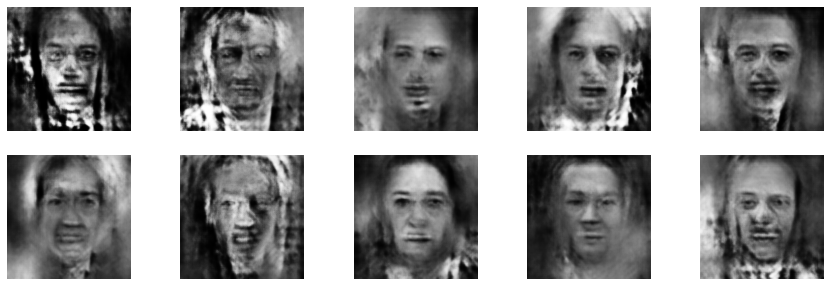


>181, 1/16, d=0.704, g=0.688
>181, 2/16, d=0.697, g=0.689
>181, 3/16, d=0.695, g=0.694
>181, 4/16, d=0.697, g=0.701
>181, 5/16, d=0.694, g=0.699
>181, 6/16, d=0.700, g=0.700
>181, 7/16, d=0.699, g=0.689
>181, 8/16, d=0.699, g=0.689
>181, 9/16, d=0.699, g=0.688
>181, 10/16, d=0.696, g=0.689
>181, 11/16, d=0.695, g=0.690
>181, 12/16, d=0.699, g=0.686
>181, 13/16, d=0.698, g=0.689
>181, 14/16, d=0.697, g=0.691
>181, 15/16, d=0.698, g=0.691


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=60):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		print("")
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
	 
			# create training set for the discriminator
			# X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			# d_loss, _ = d_model.train_on_batch(X, y)

			# update discriminator model weights on REAL
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
	 		# update discriminator model weights on FAKE
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# calculate avg loss
			d_loss = statistics.mean([d_loss1,d_loss2])
	 
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+179, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100

# Create/Load the discriminator
d_model = load_model('drive/My Drive/Colab Notebooks/Drawing to Real/Discriminator Models/discriminator_model_178.h5')
d_model.trainable = True
opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=.5)
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# d_model = define_discriminator()

# Create/Load the generator
g_model = load_model('drive/My Drive/Colab Notebooks/Drawing to Real/Generator Models/generator_model_178.h5')
# g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset = load_real_samples()

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

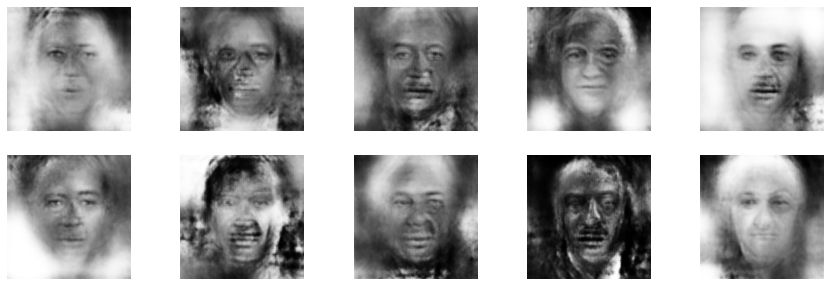

In [ ]:
g_model = load_model('drive/My Drive/Colab Notebooks/Drawing to Real/Generator Models/generator_model_120.h5')
X, _ = generate_fake_samples(g_model, latent_dim=100, n_samples=10)
X *= 255
# plot the generated samples
plt.figure(figsize=(15,5))
for i in range(10):
  # define subplot
  plt.subplot(2, 5, 1 + i)
  # turn off axis labels
  plt.axis('off')
  # plot single image
  plt.imshow(X[i, :, :, 0], cmap='gray', vmin=0, vmax=255)
  # show the figure
plt.show()

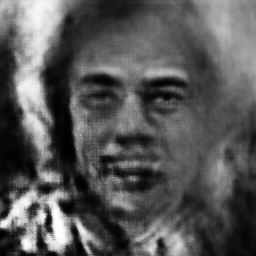

In [ ]:
# g_model = load_model('drive/My Drive/Colab Notebooks/Drawing to Real/Generator Models/generator_model_174.h5')
X, _ = generate_fake_samples(g_model, latent_dim=100, n_samples=1)
X *= 255
cv2_imshow(X[0, :, :, 0])

In [ ]:
# function ConnectButton(){
#     console.log("Connect pushed"); 
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);

function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)